In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import signal
import numpy as np
import pandas as pd
import pickle

eng_peak = 'fep'
home_dir = '/nas/longleaf/home/kbhimani/'
padding_length = 600 
scratch_dir = '/work/users/k/b/kbhimani/'



In [2]:
def event_loader_data(address, elow=-99999, ehi=99999):
    wf_list = []
    with (open(address, "rb")) as openfile:
        while True:
            try:
                wdict = pickle.load(openfile, encoding='latin1')
                wf = wdict["wf"]
                wf_list.append(wf)
            except EOFError:
                break
    return wf_list

# Function to normalize data between 0 and 1
def normalize_data(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (data - min_val) / (max_val - min_val)

det_pulses = event_loader_data(home_dir + f'CPU-Net/training_data/{eng_peak}_wf_ornl.pickle')
sim_pulses = event_loader_data(home_dir + f'CPU-Net/training_data/{eng_peak}_wf_sim.pickle')
# Pad the waveform with zeros at the beginning
for i in range(len(sim_pulses)):
    sim_pulses[i] = np.pad(sim_pulses[i], (padding_length, 0), mode='constant')
    

100%|██████████| 110403/110403 [01:31<00:00, 1207.94it/s]


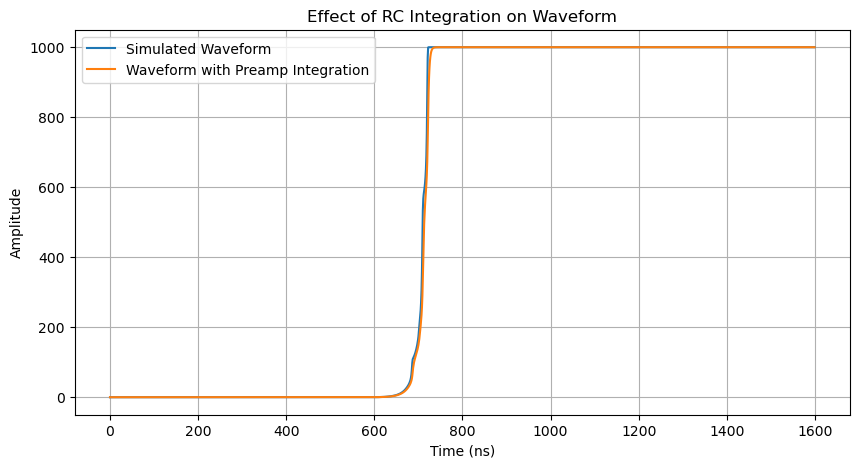

In [3]:
data_in_preamp = sim_pulses

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define the RC integration function in Python
def rc_integrate(waveform, tau):
    """
    Apply RC integration to the input waveform.
    
    Args:
    - waveform (array-like): Input signal to be integrated.
    - tau (float): Time constant for integration, representing RC.
    
    Returns:
    - integrated_waveform (np.ndarray): The waveform after applying RC integration.
    """
    time_steps = len(waveform)
    s_out = np.zeros(time_steps)  # Output array initialized to zero

    if tau < 1.0:
        s_out[1:] = waveform[:-1]  # Shift input signal if tau is less than 1
        s_out[0] = 0.0
    else:
        s_in_old = waveform[0]  # Initial value for the first step
        s_out[0] = 0.0  # Set initial output to zero
        for j in range(1, time_steps):
            # Update the output using the discrete RC integration formula
            s_out[j] = s_out[j - 1] + (s_in_old - s_out[j - 1]) / tau
            s_in_old = waveform[j]

    return s_out


tau_preamp = 50/16 # 70 ns divide by 16 ns sample rate
wf_with_preamp_list = []

# Apply RC integration to each waveform
for waveform in tqdm(data_in_preamp):
    preamp_waveform = rc_integrate(waveform, tau_preamp)
    wf_with_preamp_list.append(preamp_waveform)
# Plotting an example to see the RC integration effect
plt.figure(figsize=(10, 5))
plt.plot(sim_pulses[0], label='Simulated Waveform')
plt.plot(wf_with_preamp_list[0], label='Waveform with Preamp Integration')
plt.legend()
plt.title('Effect of RC Integration on Waveform')
plt.xlabel('Time (ns)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

In [4]:
# sim_noise_in = wf_with_preamp_list

# # Function to process waveforms
# def process_waveforms(data, max_length):
#     waveform_list = []
#     sigma_values = []
#     max_values = []

#     for waveform in data:
#         waveform_list.append(waveform)

#     for waveform in waveform_list:
#         y_values = waveform[:max_length].astype(float)
#         y_values -= y_values.mean()

#         max_value = np.max(waveform)
#         max_values.append(max_value)

#         squared_sum = (y_values ** 2).sum()
#         sigma = np.sqrt(squared_sum / len(y_values))
#         sigma_values.append(sigma)
    
#     average_sigma = np.mean(sigma_values)
#     print(f"Average sigma: {average_sigma}")

#     max_amp = np.mean(max_values)
#     print(f"Average of max values (max_amp): {max_amp}")

#     return average_sigma, max_amp, waveform_list, sigma_values

# average_sigma, max_amp, waveform_list, sigma_values = process_waveforms(det_pulses, 800)

# # Function to normalize data between 0 and 1
# def normalize_data(data):
#     min_val = np.min(data)
#     max_val = np.max(data)
#     return (data - min_val) / (max_val - min_val)

# # Normalize the noise based on sigma values
# normalized_sigma = normalize_data(sigma_values)

# # Generate pink noise and scale by normalized sigma
# def pink_noise(N):
#     freqs = np.fft.rfftfreq(N)
#     S = 1 / np.where(freqs == 0, float('inf'), np.sqrt(freqs))
#     X_white = np.fft.rfft(np.random.randn(N))
#     X_shaped = X_white * S
#     noise = np.fft.irfft(X_shaped, n=N)
#     return noise / np.sqrt(np.mean(noise**2))  # Normalize the noise

# # Apply the noise to each simulation with padding
# wf_with_noise_list = []

# for i in tqdm(range(len(sim_noise_in))):
#     # Normalize the simulated waveform
#     sim_waveform = normalize_data(sim_noise_in[i])
#     # Generate and add noise
#     noise = pink_noise(len(sim_waveform)) * normalized_sigma[i % len(normalized_sigma)]
#     noisy_sim_waveform = sim_waveform + noise
    
#     wf_with_noise_list.append(noisy_sim_waveform)

# # Plotting example
# # plt.plot(wf_with_noise_list[0], alpha=1, label='Sim with preamp')
# plt.plot(wf_with_noise_list[0], alpha=1, label='Sim with Noise + preamp')
# plt.legend()
# plt.show()

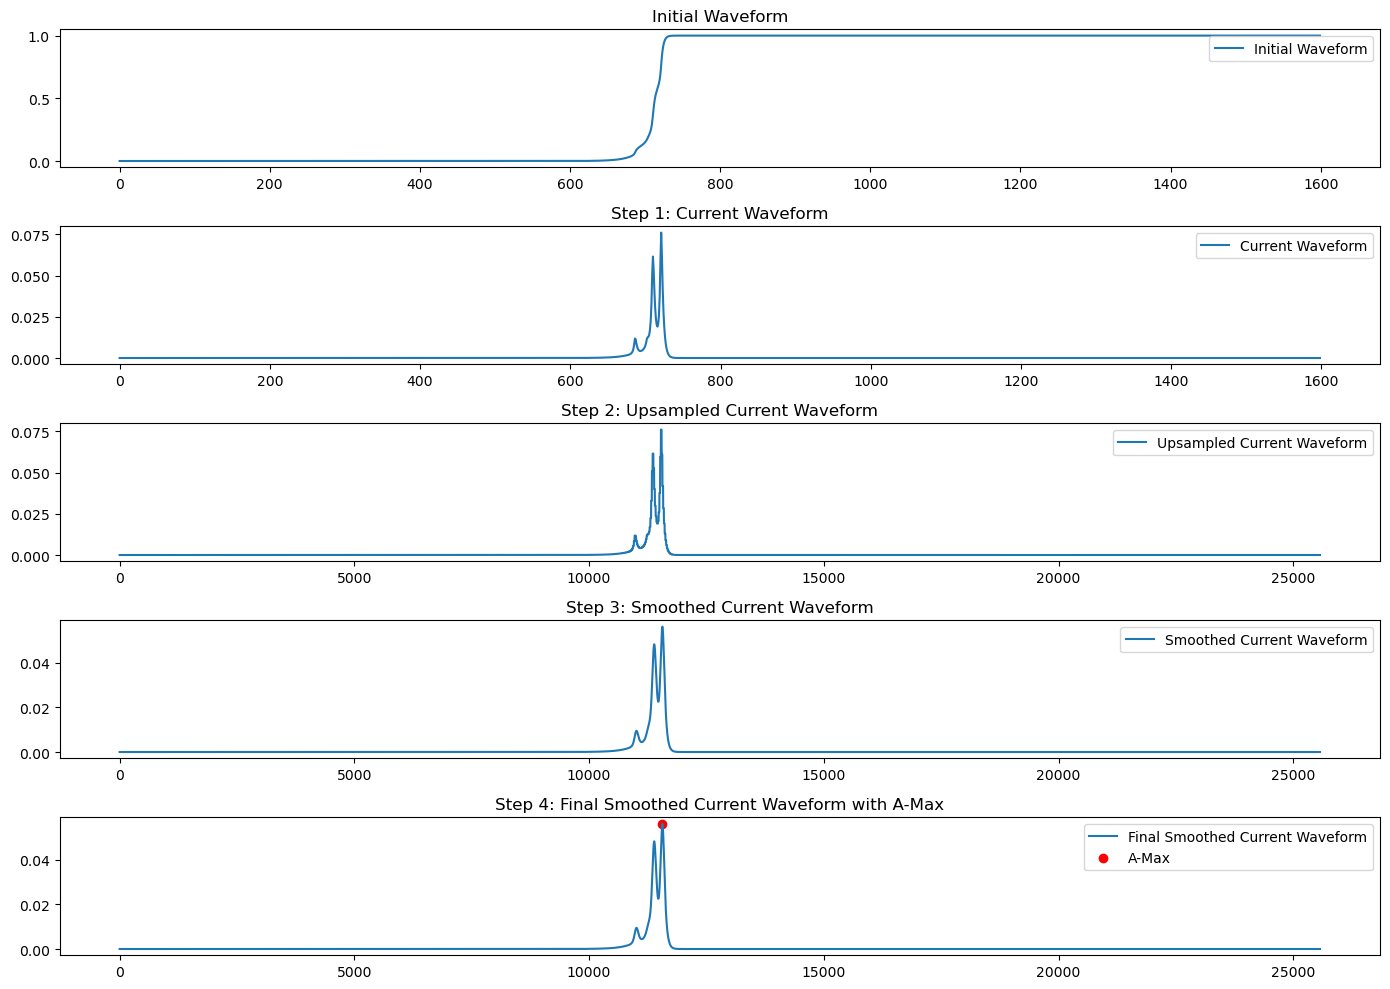

0.05607764597877114

In [5]:
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
import torch
import torch.nn as nn
import torch.autograd as autograd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm
from dspeed.processors import avg_current, upsampler, moving_window_multi, min_max, time_point_thresh
from dspeed.errors import DSPFatal

def calc_current_amplitude(waveform, plot=False):
    """
    Process a waveform through the specified DSP chain, with optional plotting.
    
    Parameters:
    waveform : numpy.ndarray
        The waveform to process.
    plot : bool
        Whether to plot the intermediate steps.
    
    Returns:
    A_max : float
        The maximum amplitude of the current waveform after processing.
    """
    waveform = waveform/1000
    if plot:
        plt.figure(figsize=(14, 10))  # Increased figure size
        
        plt.subplot(5, 1, 1)  # Added subplot for initial waveform
        plt.plot(waveform, label="Initial Waveform")
        plt.title("Initial Waveform")
        plt.legend()

    # Step 1: Calculate the current waveform
    current = np.zeros(len(waveform) - 1)
    avg_current(waveform, 1, current)
    
    # Plot the current waveform
    if plot:
        plt.subplot(5, 1, 2)
        plt.plot(current, label="Current Waveform")
        plt.title("Step 1: Current Waveform")
        plt.legend()
    
    # Step 2: Upsample the current waveform
    upsample_factor = 16
    upsampled_current = np.zeros((len(current) - 1) * upsample_factor)
    upsampler(current, upsample_factor, upsampled_current)
    
    # Plot the upsampled current waveform
    if plot:
        plt.subplot(5, 1, 3)
        plt.plot(upsampled_current, label="Upsampled Current Waveform")
        plt.title("Step 2: Upsampled Current Waveform")
        plt.legend()
    
    # Step 3: Apply moving window to the upsampled current
    window_length = 48
    num_mw = 3
    mw_type = 0  # Alternate moving windows right and left
    smoothed_current = np.zeros_like(upsampled_current)
    moving_window_multi(upsampled_current, window_length, num_mw, mw_type, smoothed_current)
    
    # Plot the smoothed current waveform
    if plot:
        plt.subplot(5, 1, 4)
        plt.plot(smoothed_current, label="Smoothed Current Waveform")
        plt.title("Step 3: Smoothed Current Waveform")
        plt.legend()
    
    # Step 4: Find A-Max in the smoothed current waveform
    t_min, t_max, A_min, A_max = np.zeros(1), np.zeros(1), np.zeros(1), np.zeros(1)
    min_max(smoothed_current, t_min, t_max, A_min, A_max)
    
    # Plot the final waveform highlighting A-Max
    if plot:
        plt.subplot(5, 1, 5)
        plt.plot(smoothed_current, label="Final Smoothed Current Waveform")
        plt.scatter(t_max, A_max, color='red', label="A-Max")
        plt.title("Step 4: Final Smoothed Current Waveform with A-Max")
        plt.legend()
        plt.tight_layout()  # Adjust layout to make sure everything fits
        plt.show()
    
    return A_max[0]
calc_current_amplitude(wf_with_preamp_list[0],plot=True)

We add pink noise to the data by calculating the standard deviation of the data and also pad the simulations to have some baseline

Now we add a single pole zero decay to the simulations

100%|██████████| 110403/110403 [11:49<00:00, 155.69it/s]


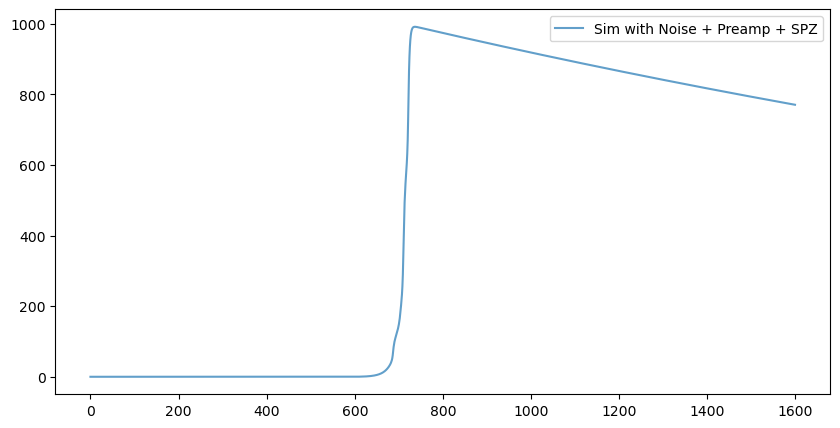

In [6]:
# Define transfer functions

data_in_rc = wf_with_preamp_list
# tau = 33700 / 16
tau=1/0.0002930712583517658 # this was determined to fitting the real data. 1/tau is negative slope of linear fit of log of waveform tail
num1 = [1, 0]
den1 = [1, 1 / tau]
sys1 = signal.TransferFunction(num1, den1)


def apply_transfer_function(waveform, sys):
    _, y_response, _ = signal.lsim(sys, waveform, np.arange(len(waveform)))
    return y_response


# Initialize lists to hold transformed waveforms
wf_with_spz_list = []

# Scale and apply transfer functions
for waveform in tqdm(data_in_rc):
    # Normalize the waveform
    transformed = apply_transfer_function(waveform, sys1)
    normalized_waveform = normalize_data(transformed)
    wf_with_spz_list.append(transformed)
# Plotting example
plt.figure(figsize=(10, 5))
# plt.plot(wf_with_noise_list[0], label='Sim with Noise + Preamp', alpha = 0.7)
plt.plot(wf_with_spz_list[0], label='Sim with Noise + Preamp + SPZ', alpha = 0.7)
plt.legend()
plt.show()

In [7]:
data = wf_with_spz_list
pickle_path_1 = scratch_dir+f'cpu_net_datasets/{eng_peak}_sim_preamp_pz.pkl'
with open(pickle_path_1, 'wb') as f_data:
    for index in tqdm(data, total=len(data), desc="Processing Data"):
        event_id = index  
        energy = 2614.5
        # Process 'data_column'
        waveform_data = np.array(index)
        if waveform_data is not None:
            event_dict_data = {
                "tp0": padding_length,
                "wf": waveform_data.astype(np.float32),
                "event": event_id,
                "energy": energy,
            }
            pickle.dump(event_dict_data, f_data, protocol=pickle.HIGHEST_PROTOCOL)
    print("Completed saving waveforms.")

Processing Data: 100%|██████████| 110403/110403 [00:03<00:00, 31372.45it/s]


Completed saving waveforms.


Repeat the same code to save sim + noise + pz

In [12]:
def event_loader_data(address, elow=-99999, ehi=99999):
    wf_list = []
    with (open(address, "rb")) as openfile:
        while True:
            try:
                wdict = pickle.load(openfile, encoding='latin1')
                wf = wdict["wf"]
                wf_list.append(wf)
            except EOFError:
                break
    return wf_list

det_pulses = event_loader_data(home_dir + f'CPU-Net/training_data/{eng_peak}_wf_ornl.pickle')
sim_pulses = event_loader_data(home_dir + f'CPU-Net/training_data/{eng_peak}_wf_sim.pickle')
# Pad the waveform with zeros at the beginning
for i in range(len(sim_pulses)):
    sim_pulses[i] = np.pad(sim_pulses[i], (padding_length, 0), mode='constant')
    

In [13]:
# sim_noise_in = sim_pulses

# # Function to process waveforms
# def process_waveforms(data, max_length):
#     waveform_list = []
#     sigma_values = []
#     max_values = []

#     for waveform in data:
#         waveform_list.append(waveform)

#     for waveform in waveform_list:
#         y_values = waveform[:max_length].astype(float)
#         y_values -= y_values.mean()

#         max_value = np.max(waveform)
#         max_values.append(max_value)

#         squared_sum = (y_values ** 2).sum()
#         sigma = np.sqrt(squared_sum / len(y_values))
#         sigma_values.append(sigma)
    
#     average_sigma = np.mean(sigma_values)
#     print(f"Average sigma: {average_sigma}")

#     max_amp = np.mean(max_values)
#     print(f"Average of max values (max_amp): {max_amp}")

#     return average_sigma, max_amp, waveform_list, sigma_values

# average_sigma, max_amp, waveform_list, sigma_values = process_waveforms(det_pulses, 800)

# # Function to normalize data between 0 and 1
# def normalize_data(data):
#     min_val = np.min(data)
#     max_val = np.max(data)
#     return (data - min_val) / (max_val - min_val)

# # Normalize the noise based on sigma values
# normalized_sigma = normalize_data(sigma_values)

# # Generate pink noise and scale by normalized sigma
# def pink_noise(N):
#     freqs = np.fft.rfftfreq(N)
#     S = 1 / np.where(freqs == 0, float('inf'), np.sqrt(freqs))
#     X_white = np.fft.rfft(np.random.randn(N))
#     X_shaped = X_white * S
#     noise = np.fft.irfft(X_shaped, n=N)
#     return noise / np.sqrt(np.mean(noise**2))  # Normalize the noise

# # Apply the noise to each simulation with padding
# wf_with_noise_list = []

# for i in tqdm(range(len(sim_noise_in))):
#     # Normalize the simulated waveform
#     sim_waveform = normalize_data(sim_noise_in[i])
#     # Generate and add noise
#     noise = pink_noise(len(sim_waveform)) * normalized_sigma[i % len(normalized_sigma)]
#     noisy_sim_waveform = sim_waveform + noise
    
#     wf_with_noise_list.append(noisy_sim_waveform)

# # Plotting example
# # plt.plot(wf_with_noise_list[0], alpha=1, label='Sim with preamp')
# plt.plot(wf_with_noise_list[0], alpha=1, label='Sim with Noise + preamp')
# plt.legend()
# plt.show()

100%|██████████| 110403/110403 [14:16<00:00, 128.86it/s]


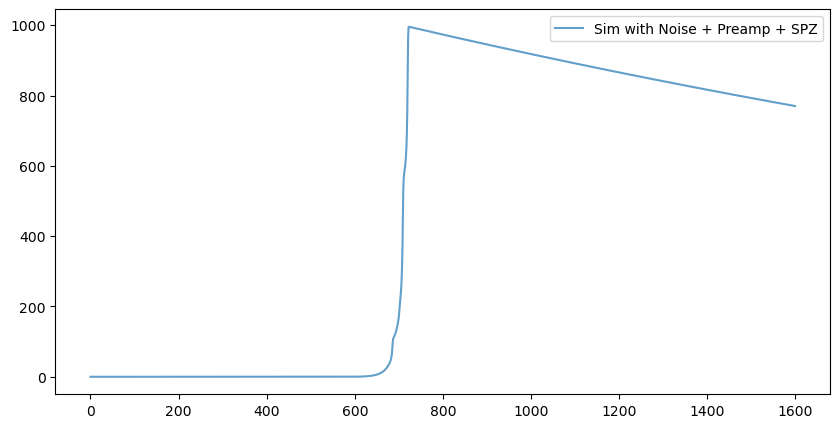

In [14]:
# Define transfer functions

data_in_rc = sim_pulses
# tau = 33700 / 16
tau=1/0.0002930712583517658 # this was determined to fitting the real data. 1/tau is negative slope of linear fit of log of waveform tail
num1 = [1, 0]
den1 = [1, 1 / tau]
sys1 = signal.TransferFunction(num1, den1)


def apply_transfer_function(waveform, sys):
    _, y_response, _ = signal.lsim(sys, waveform, np.arange(len(waveform)))
    return y_response


# Initialize lists to hold transformed waveforms
wf_with_spz_list = []

# Scale and apply transfer functions
for waveform in tqdm(data_in_rc):
    # Normalize the waveform
    transformed = apply_transfer_function(waveform, sys1)
    normalized_waveform = normalize_data(transformed)
    wf_with_spz_list.append(transformed)
# Plotting example
plt.figure(figsize=(10, 5))
# plt.plot(wf_with_noise_list[0], label='Sim with Noise + Preamp', alpha = 0.7)
plt.plot(wf_with_spz_list[0], label='Sim with Noise + Preamp + SPZ', alpha = 0.7)
plt.legend()
plt.show()

In [15]:
data = wf_with_spz_list
pickle_path_1 = scratch_dir+f'cpu_net_datasets/{eng_peak}_sim_pz.pkl'
with open(pickle_path_1, 'wb') as f_data:
    for index in tqdm(data, total=len(data), desc="Processing Data"):
        event_id = index  
        energy = 2614.5
        # Process 'data_column'
        waveform_data = np.array(index)
        if waveform_data is not None:
            event_dict_data = {
                "tp0": padding_length,
                "wf": waveform_data.astype(np.float32),
                "event": event_id,
                "energy": energy,
            }
            pickle.dump(event_dict_data, f_data, protocol=pickle.HIGHEST_PROTOCOL)
    print("Completed saving waveforms.")

Processing Data: 100%|██████████| 110403/110403 [00:03<00:00, 31681.20it/s]


Completed saving waveforms.
